<a href="https://colab.research.google.com/github/adamd1985/Lectures_On_MLAI/blob/main/5_3_Agglomerative_Lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hierarchical Clustering - Agglomerative

This notebook implements the algorithms taught in the lesson on Hierarchical Clustering.

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

# Linkage Functions

Agglomerative clustering is a hierarchical clustering method that builds clusters by iteratively merging smaller clusters. The way clusters are merged is determined by the **linkage function**.



## Single Linkage

Single linkage calculates the distance between two clusters as the **shortest** distance between any two points in the clusters.

Given two clusters $C_1$ and $C_2$, the single linkage distance is:

$$
d(C_1, C_2) = \min_{x \in C_1, y \in C_2} ||x - y||
$$

In [103]:
def single_linkage(cluster1, cluster2):
    return np.min([np.linalg.norm(p1 - p2) for p1 in cluster1 for p2 in cluster2])

cluster_a = np.array([[1, 2], [3, 4], [5, 6]])
cluster_b = np.array([[7, 8], [9, 10], [11, 12]])

print("Single Linkage:", single_linkage(cluster_a, cluster_b))

Single Linkage: 2.8284271247461903


## Complete Linkage

Complete linkage defines the distance between two clusters as the **maximum** distance between any two points in the clusters.

$$
d(C_1, C_2) = \max_{x \in C_1, y \in C_2} ||x - y||
$$


In [104]:
def complete_linkage(cluster1, cluster2):
    return np.max([np.linalg.norm(p1 - p2) for p1 in cluster1 for p2 in cluster2])

print("Complete Linkage:", complete_linkage(cluster_a, cluster_b))

Complete Linkage: 14.142135623730951


## Average Linkage

Average linkage calculates the distance between two clusters as the **average** distance between all pairs of points from the two clusters.

$$
d(C_1, C_2) = \frac{1}{|C_1||C_2|} \sum_{x \in C_1} \sum_{y \in C_2} ||x - y||
$$


In [105]:
def average_linkage(cluster1, cluster2):
    distances = [np.linalg.norm(p1 - p2) for p1 in cluster1 for p2 in cluster2]
    return np.mean(distances)

print("Average Linkage:", average_linkage(cluster_a, cluster_b))

Average Linkage: 8.485281374238571


## Centroid Linkage

Centroid linkage defines the distance between two clusters as the Euclidean distance between their **centroids**.

Let the centroid of cluster $C_1$ be:

$$
\mu_1 = \frac{1}{|C_1|} \sum_{x \in C_1} x
$$

and the centroid of cluster $C_2$ be:

$$
\mu_2 = \frac{1}{|C_2|} \sum_{y \in C_2} y
$$

The centroid linkage distance is:

$$
d(C_1, C_2) = ||\mu_1 - \mu_2||
$$

In [106]:
def centroid_linkage(cluster1, cluster2):
    centroid1 = np.mean(cluster1, axis=0)
    centroid2 = np.mean(cluster2, axis=0)
    return np.linalg.norm(centroid1 - centroid2)

print("Centroid Linkage:", centroid_linkage(cluster_a, cluster_b))

Centroid Linkage: 8.48528137423857


# Pairwise Distance and Distance Matrix

In hierarchical clustering, we require a **distance matrix**, which represents the pairwise distances between data points. This matrix is fundamental in determining how clusters are merged. Below, we define the pairwise distance calculations and how to construct a **distance matrix manually**.

We assume you already know Euclidean distance.

Given a dataset $X$ with $n$ points, the **distance matrix** is an $n \times n$ matrix $D$, where each entry is the distance between two points:

$$
D_{ij} = d(x_i, x_j)
$$

The matrix is **symmetric**, meaning:

$$
D_{ij} = D_{ji}, \quad \text{and} \quad D_{ii} = 0
$$

since the distance of any point to itself is zero.


To construct the distance matrix, we:
1. Initialize an $n \times n$ zero matrix.
2. Iterate through each pair of points $(x_i, x_j)$, computing the Euclidean distance.
3. Store the distance in both $D_{ij}$ and $D_{ji}$ to maintain symmetry.

for a dataset $X$ with $n$ data points:

$$
D =
\begin{bmatrix}
0 & d(x_1, x_2) & d(x_1, x_3) & \dots & d(x_1, x_n) \\
d(x_2, x_1) & 0 & d(x_2, x_3) & \dots & d(x_2, x_n) \\
d(x_3, x_1) & d(x_3, x_2) & 0 & \dots & d(x_3, x_n) \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
d(x_n, x_1) & d(x_n, x_2) & d(x_n, x_3) & \dots & 0
\end{bmatrix}
$$

where each $d(x_i, x_j)$ is computed using the Euclidean formula.

In [107]:
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

def compute_distance_matrix(data):
    n = len(data)
    distance_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            if i == j:
                distance_matrix[i, j] = 0
            else:
                dist = euclidean_distance(data[i], data[j])
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist

    return distance_matrix

data = np.array([
    [1, 2],
    [3, 4],
    [5, 6],
    [7, 8]
])

dist_matrix_manual = compute_distance_matrix(data)
print("Manually Computed Distance Matrix:")
print(dist_matrix_manual)

Manually Computed Distance Matrix:
[[0.         2.82842712 5.65685425 8.48528137]
 [2.82842712 0.         2.82842712 5.65685425]
 [5.65685425 2.82842712 0.         2.82842712]
 [8.48528137 5.65685425 2.82842712 0.        ]]


# Algorithm

1. **Initialize**: Treat each data point as a separate cluster.
2. **Compute Distance Matrix**: Calculate the pairwise distances between all clusters.
3. **Merge Closest Clusters**: Identify the two clusters with the smallest distance based on a chosen **linkage function**.
4. **Update the Distance Matrix**: Recalculate distances between the newly merged cluster and all other clusters.
5. **Repeat**: Continue merging until only one cluster remains.



In [108]:
def agglomerative_clustering(data, linkage_func, min_clusters=1, distance_threshold=None):
    n = len(data)
    clusters = {i: [data[i]] for i in range(n)}
    cluster_labels = {i: i for i in range(n)}

    while len(clusters) > min_clusters:
        min_dist = float("inf")
        merge_a, merge_b = None, None

        keys = list(clusters.keys())
        for i in tqdm(range(len(keys)), leave=False):
            for j in range(i + 1, len(keys)):
                c1, c2 = keys[i], keys[j]
                dist = linkage_func(clusters[c1], clusters[c2])

                if dist < min_dist:
                    min_dist = dist
                    merge_a, merge_b = c1, c2

        if merge_a is not None and merge_b is not None:
            # Stop if distance threshold is provided and exceeded
            if distance_threshold is not None and min_dist > distance_threshold:
                break

            clusters[merge_a] += clusters[merge_b]
            del clusters[merge_b]
            for k, v in cluster_labels.items():
                if v == merge_b:
                    cluster_labels[k] = merge_a

    final_clusters = {v: [] for v in set(cluster_labels.values())}
    for k, v in cluster_labels.items():
        final_clusters[v].append(k)

    return list(final_clusters.values())

data = np.array([
    [1, 2],
    [3, 4],
    [5, 6],
    [7, 8]
])


linkage_methods = {
    "single": single_linkage,
    "complete": complete_linkage,
    "average": average_linkage,
    "centroid": centroid_linkage
}

for name, func in linkage_methods.items():
    print(f"Clustering with {name} linkage:")
    clusters = agglomerative_clustering(data, func)
    print(clusters)

Clustering with single linkage:


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[[0, 1, 2, 3]]
Clustering with complete linkage:


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[[0, 1, 2, 3]]
Clustering with average linkage:


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[[0, 1, 2, 3]]
Clustering with centroid linkage:


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[[0, 1, 2, 3]]


## Prediction Function

To assign a **new, unseen data point** to one of the existing clusters, we:
1. Compute the **distance** between the new point and all formed clusters.
2. Assign the point to the **nearest cluster** based on the chosen linkage function.


In [109]:
from scipy.spatial.distance import cdist

def predict_cluster(new_point, clusters, linkage_func):
    min_dist = float("inf")
    best_cluster = None

    for cluster_id, cluster_points in enumerate(clusters):
        cluster_data = X[cluster_points]
        dist = linkage_func([new_point], cluster_data)

        if dist < min_dist:
            min_dist = dist
            best_cluster = cluster_id

    return best_cluster

np.random.seed(42)
random_test_point = np.random.uniform(low=np.min(X, axis=0), high=np.max(X, axis=0))

clusters = agglomerative_clustering(X, single_linkage, min_clusters=3)
predicted_cluster = predict_cluster(random_test_point, clusters, single_linkage)
print(f"Random Test Point: {random_test_point}")
print(f"Predicted Cluster: {predicted_cluster}")

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Random Test Point: [5.64834443 4.28171434 5.31876426 1.53678036]
Predicted Cluster: 1


Applying it to Iris.

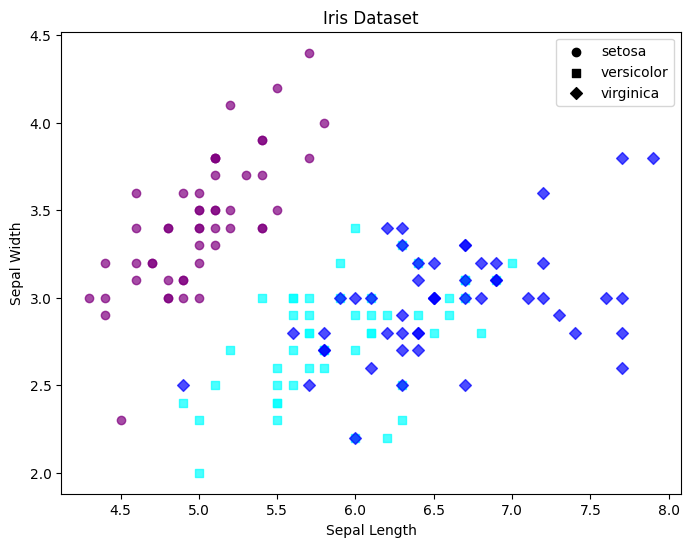

In [110]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
X, y = iris.data.values, iris.target.values
cluster_colors = ['purple', 'cyan', 'blue', 'yellow', 'red', 'orange', 'gray']
markers = ['o', 's', 'D']
plt.figure(figsize=(8, 6))
for i, name in enumerate(iris.target_names):
    plt.scatter([], [], marker=markers[i], color='black', label=f"{name}")
for i in range(len(X)):
    plt.scatter(X[i, 0], X[i, 1],
                marker=markers[y[i]],
                color=cluster_colors[y[i]],
                alpha=0.7)

plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.title('Iris Dataset')
plt.legend()
plt.show()

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

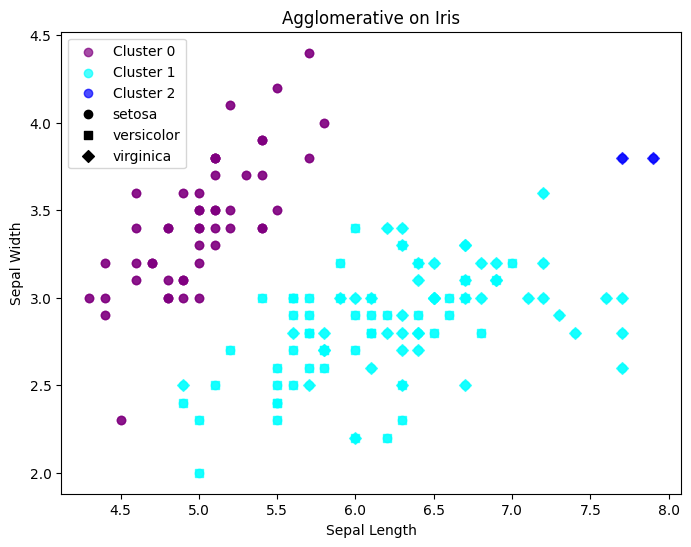

In [111]:
clusters_= agglomerative_clustering(X, single_linkage, min_clusters=3)
cluster_assignments_= np.zeros(len(X))
for cluster_id, cluster_points in enumerate(clusters_):
    for point_idx in cluster_points:
        cluster_assignments_[point_idx] = cluster_id

unique_clusters_= np.unique(cluster_assignments_)
plt.figure(figsize=(8, 6))
for cluster_id, color in zip(unique_clusters_, cluster_colors):
    cluster_points = X[cluster_assignments_== cluster_id]
    plt.scatter(cluster_points[:, 0],
                cluster_points[:, 1],
                color=color, alpha=0.7, label=f'Cluster {int(cluster_id)}')
for i, name in enumerate(iris.target_names):
    plt.scatter([], [], marker=markers[i], color='black', label=f"{name}")
for i in range(len(X)):
    plt.scatter(X[i, 0], X[i, 1],
                marker=markers[y[i]],  # Use actual species-based markers
                color=cluster_colors[int(cluster_assignments_[i])],
                alpha=0.7)


plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.title('Agglomerative on Iris')
plt.legend()
plt.show()

In [112]:
from sklearn.metrics import silhouette_score

cluster_labels = np.zeros(len(X))
for cluster_id, cluster_points in enumerate(clusters_):
    for point_idx in cluster_points:
        cluster_labels[point_idx] = cluster_id

silhouette_avg = silhouette_score(X, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.5121107753649314


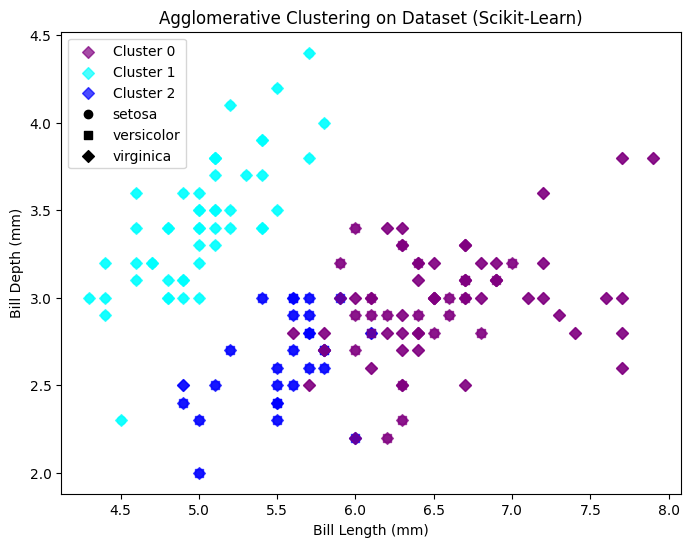

In [113]:
from sklearn.cluster import AgglomerativeClustering

agglom = AgglomerativeClustering(linkage='complete', n_clusters=None, distance_threshold=4)
cluster_assignments_= agglom.fit_predict(X)

plt.figure(figsize=(8, 6))
for cluster_id in np.unique(cluster_assignments_):
    cluster_points = X[cluster_assignments_== cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                color=cluster_colors[int(cluster_id)],
                alpha=0.7, label=f'Cluster {int(cluster_id)}')

for i, name in enumerate(iris.target_names):
    plt.scatter([], [], marker=markers[i], color='black', label=f"{name}")
for i in range(len(X)):
    plt.scatter(X[i, 0], X[i, 1],
                marker=markers[y[i]],  # Use actual species-based markers
                color=cluster_colors[int(cluster_assignments_[i])],
                alpha=0.7)

plt.xlabel('Bill Length (mm)')
plt.ylabel('Bill Depth (mm)')
plt.title('Agglomerative Clustering on Dataset (Scikit-Learn)')
plt.legend()
plt.show()

In [114]:
silhouette_avg = silhouette_score(X, cluster_assignments_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.5135953221192219


<Figure size 1000x600 with 0 Axes>

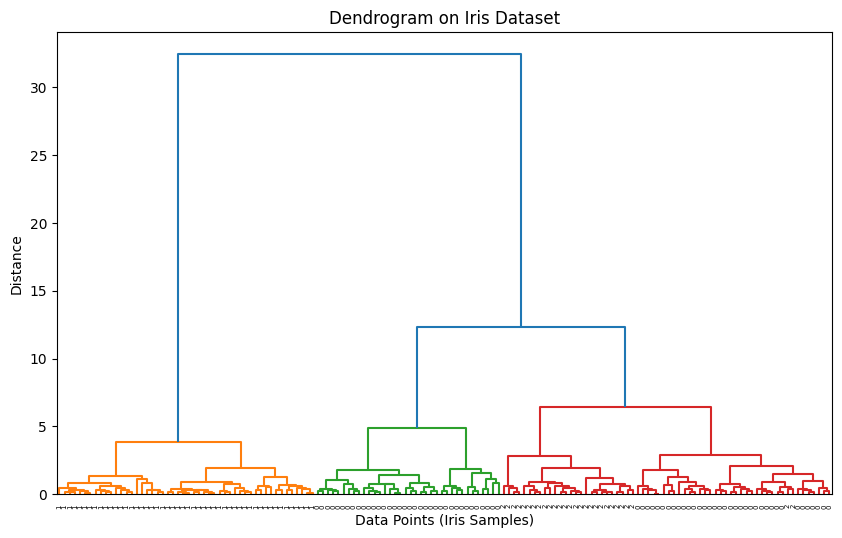

In [115]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(10, 6))
linked = sch.linkage(X, method='ward')

plt.figure(figsize=(10, 6))
sch.dendrogram(linked, labels=cluster_assignments_, color_threshold=7)

plt.xlabel('Data Points (Iris Samples)')
plt.ylabel('Distance')
plt.title('Dendrogram on Iris Dataset')
plt.show()

# Conclusion


In this lesson, we explored **Agglomerative Clustering**, a powerful **hierarchical clustering** technique that builds clusters in a **bottom-up** fashion. We applied it to the **Iris dataset**, analyzed its clustering behavior using **dendrograms**, and implemented a **prediction function** to classify new data points.

**Agglomerative Clustering** starts with each data point as its own cluster and iteratively merges them based on a chosen **linkage function**.
The result is a **hierarchical structure** that can be visualized using a **dendrogram**.

- **Single Linkage**: Can create long, chain-like clusters.
- **Complete Linkage**: Produces compact, well-separated clusters.
- **Average Linkage**: Averages distances, balancing between compactness and separation.
- **Centroid Linkage**: Merges clusters based on their center points.


A **dendrogram** helps us visualize how clusters merge at different distances.
Choosing an appropriate **distance threshold** allows us to control the **number of final clusters**.
We found that **a threshold of 7-10** resulted in **three natural clusters**, aligning well with the **three Iris species**.


Agglomerative Clustering is a powerful technique that **uncovers natural patterns in data**. Understanding its strengths, limitations, and visualization tools like **dendrograms** enables us to **extract deeper insights** from complex datasets.
